2022-10-04 17:04:01.223440: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-04 17:04:01.419441: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-04 17:04:01.513859: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-04 17:04:02.255287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

finding sae weights....


2022-10-04 17:04:03.809219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 17:04:03.873394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 17:04:03.873530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 17:04:03.874187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

177/177 [==============================] - 0s 555us/step
done, processing time: 35.74013161659241
36/36 [==============================] - 0s 714us/step
CV number:  0
accuracy of :>0.805
F1 of :>0.841
Precision of :>0.847
Recall of :>0.849
36/36 [==============================] - 0s 715us/step
CV number:  1
accuracy of :>0.798
F1 of :>0.809
Precision of :>0.812
Recall of :>0.813
36/36 [==============================] - 0s 715us/step
CV number:  2
accuracy of :>0.783
F1 of :>0.856
Precision of :>0.849
Recall of :>0.894
35/35 [==============================] - 0s 1ms/step
CV number:  3
accuracy of :>0.804
F1 of :>0.875
Precision of :>0.871
Recall of :>0.901
36/36 [==============================] - 0s 743us/step
CV number:  4
accuracy of :>0.761
F1 of :>0.775
Precision of :>0.779
Recall of :>0.782
waktu proses:  175.69375109672546
Accuracy array: [0.8051146384479718, 0.7977132805628848, 0.7831858407079646, 0.8044642857142857, 0.7608503100088574]
F1 array: [0.8405475770555136, 0.8090756795

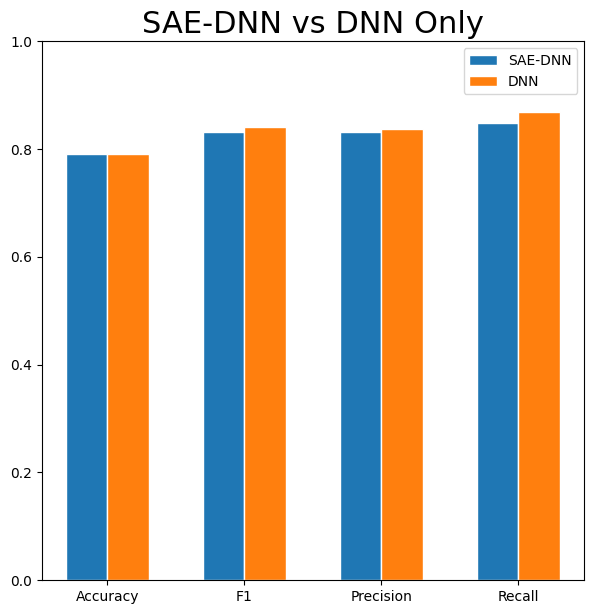

In [1]:
# Numpy, pandas, time
import numpy as np
import pandas as pd
import time

# Iterative Stratification untuk cross validation multilabel
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow import keras

#import models
from src.sae_dnn_model import sae_model, dnn_model
from src.iterative_strat_modif import new_init
from src.visualize import visual
from src.print import print_metric

from datetime import datetime
from packaging import version

#Modifikasi IterativeStratification agar hasil random data tetap sama    
IterativeStratification.__init__ = new_init
# define evaluation procedure
np.random.seed(123)
#Inisialisasi CV
cv = IterativeStratification(n_splits=5, random_state = 123)

#Main Code 
def res_sae_dnn(X, hl_node, lr, opt, num_layers, do, fr_node):
  
  acc_results = list()
  f1_results = list()
  prec_results = list()
  rec_results = list()
  n_inputs, n_outputs = X.shape[1], 7
  
  print("finding sae weights....")
  ti0 = time.time()

  sae_weigths_tuned = sae_model(xt = X, hl_node = hl_node, af = "relu", lr = lr, opt= opt, num_layers = num_layers,
                                do = do, fr_node= fr_node)

  ti1 = time.time()
  print('done, processing time:', ti1-ti0)
  
  i=0
  t0 = time.time()
  # enumerate folds
  np.random.seed(123)

  for train_ix, test_ix in cv.split(X,Y):
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model
    model = dnn_model(xt = X_train, sae_weights = sae_weigths_tuned, hl_node = hl_node, af = "relu", lr = lr, opt= opt, num_layers = num_layers,
                              do = do, fr_node= fr_node)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples' ,zero_division=0)
    rec = recall_score(y_test, yhat, average='samples')
    
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
  
  t1 = time.time()
  total_waktu = t1-t0

  print("waktu proses: ", total_waktu)
  print_metric(acc_results, f1_results, prec_results, rec_results)
  
  accuracy_res, f1_res, precision_res, recall_res = np.mean(acc_results), np.mean(f1_results), np.mean(prec_results), np.mean(rec_results)
  metric_sae_dnn = [accuracy_res, f1_res, precision_res, recall_res]

  model.save("models/sae_dnn_pubchem_tuned.h5")

  return [metric_sae_dnn, total_waktu]


def dnn_saja(X, hl_node, lr, opt, num_layers, do, fr_node):
  acc_results = list()
  f1_results = list()
  prec_results = list()
  rec_results = list()
  n_inputs, n_outputs = X.shape[1], 7
  
  logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
  
  
  # define evaluation procedure
  # cv = IterativeStratification(n_splits=5, random_state = 123)
  i=0
  # enumerate folds
  t0 = time.time()

  for train_ix, test_ix in cv.split(X,Y):
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model tanpa bobot SAE
    model = dnn_model(xt= X_train, sae_weights= None, hl_node= hl_node, af= "relu", lr= lr, opt= opt, num_layers= num_layers,
                              do= do, fr_node= fr_node)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples', zero_division=0)
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
  
  t1 = time.time()
  total_waktu = t1-t0
  print("waktu proses", total_waktu)
  print_metric(acc_results, f1_results, prec_results, rec_results)
  
  accuracy_res, f1_res, precision_res, recall_res = np.mean(acc_results), np.mean(f1_results), np.mean(prec_results), np.mean(rec_results)
  metric_sae_dnn = [accuracy_res, f1_res, precision_res, recall_res]

  model.save("models/dnn_only_pubchem_tuned.h5")

  return [metric_sae_dnn, total_waktu]

#datasets
df_pubchem = pd.read_csv('dataset/interim/df_pubchem_rapi.csv')
Y = pd.read_csv('dataset/interim/kelas_data.csv')
Y = np.array(Y)

#Parameter
X = df_pubchem
hl_node = 1800
fr_node = 0.66
num_layers = 2
opt = "adam"
lr = 0.1
do = 0.5

#train
hasil_saednn = res_sae_dnn(X, hl_node, lr, opt, num_layers, do, fr_node)
dnn_aja = dnn_saja(X, hl_node, lr, opt, num_layers, do, fr_node)

print("SAE-DNN training time:" + str(hasil_saednn[1]) + " seconds")
print("DNN Only training time: " + str(dnn_aja[1]) + " seconds")

#visualize saednn vs dnnonly
path = 'reports/figure'
visual(hasil_saednn[0], dnn_aja[0], "SAE-DNN vs DNN Only", path)



